In [1]:
#import the relevant libraries
import numpy as np
import pandas as pd
import tushare as ts
import datetime as datetime
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Data Handling
data = pd.read_excel('D:\PHBS\Module 3\Investments\Final Project\Index\Final\data2.xlsx')
data.fillna(method='pad', inplace= True) #Replace missing values with the previous one.
data.drop('CEI',1, inplace = True)

macro_data = data[['CPI','MCI','PPI']] #create separate macro indicators table.
data.drop(['CPI','MCI','PPI'],1)
macro_data.drop([0], inplace=True)

datat = data.drop(['CPI','MCI','PPI'],1, inplace=True) #create two parallel time series, one at time t and other at time t+1
datat = data.shift(1)
datat.drop(['Date'],1,inplace= True)
datat = datat.rename(columns={'CCI':'CCIt',
                    'SMT':'SMTt',
                    'NumIPO':'NumIPOt',
                    'NewAcc':'NewAcct',
                    'DiscCEF':'DiscCEFt',
                    'ADR':'ADRt'})
datat.fillna(method='pad', inplace= True)
all_data = pd.concat([data,datat],1) #join all the data in one dataframe
all_data.head(5)
all_data.drop([0], inplace=True)

c:\users\ricardo\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [4]:
#Regressions

X = macro_data[['CPI', 'MCI', 'PPI']] #repeat this to every indicator
y = all_data['CCI']
X = sm.add_constant(X)

model1 = sm.OLS(y, X).fit()
predictions1= model1.predict(X)

y = all_data['SMT']
X = sm.add_constant(X)

model2 = sm.OLS(y, X).fit()
prediction2= model2.predict(X)

y = all_data['NumIPO']
X = sm.add_constant(X)

model3 = sm.OLS(y, X).fit()
predictions3= model3.predict(X)

y = all_data['NewAcc']
X = sm.add_constant(X)

model4 = sm.OLS(y, X).fit()
predictions4= model4.predict(X)

y = all_data['DiscCEFt']
X = sm.add_constant(X)

model5 = sm.OLS(y, X).fit()
predictions5= model5.predict(X)

y = all_data['ADRt']
X = sm.add_constant(X)

model6 = sm.OLS(y, X).fit()
predictions6= model6.predict(X)

In [5]:
#get the residuals
macro_resid = pd.DataFrame({'CCI':model1.resid, 'SMT':model2.resid,'NumIPO':model3.resid,
                            'NewAcc':model4.resid,'DiscCEFt':model5.resid, 'ADRt':model6.resid})  #get the residuals

In [6]:
#Standardize and apply PCA on the residuals
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()   #standardize the residuals
scaler.fit(macro_resid)
scaled_data = scaler.transform(macro_resid)

pca = PCA(n_components=4)
pca.fit(scaled_data)

sel_data_scaled = pd.DataFrame(scaled_data, columns = ['CCI','SMT','NumIPO','NewAcc','DiscCEFt','ADRt'])

pca_components = pd.DataFrame(pca.components_, index = ['PCA1', 'PCA2', 'PCA3', 'PCA4'], columns = ['CCI','SMT','NumIPO','NewAcc','DiscCEFt','ADRt'])
pca_comp = pca_components.drop(['PCA2','PCA3','PCA4'])
loadings = pca_comp
for i in range(151):
   loadings = loadings.append(pca_comp, ignore_index=True)

index_fi = loadings*sel_data_scaled    #build a series

index_fi['INDEX'] = index_fi['CCI']+index_fi['SMT']+index_fi['NumIPO']+index_fi['NewAcc']+index_fi['DiscCEFt']+index_fi['ADRt']

In [8]:
pca.explained_variance_ratio_

array([0.39554469, 0.30105294, 0.13277076, 0.08069204])

In [9]:
pca.components_

array([[ 0.45052337,  0.57796994,  0.03779878,  0.46429241, -0.29596827,
         0.39797743],
       [-0.21297239,  0.00822323,  0.67082918,  0.3790483 ,  0.5804289 ,
         0.15488069],
       [-0.50935119,  0.07403718, -0.24015043, -0.23386442,  0.03194106,
         0.78847627],
       [ 0.67078531, -0.34866609,  0.20590029, -0.44174988,  0.19758197,
         0.38974671]])

In [10]:
index_fi.head(5)

,CCI,SMT,NumIPO,NewAcc,DiscCEFt,ADRt,INDEX
0,-0.039871,-0.590597,-0.042410,-0.207223,0.379701,-0.354364,-0.854765
1,0.068936,-0.087500,-0.047340,-0.160141,0.367579,-0.292429,-0.150895
2,0.053675,-0.383737,-0.055816,-0.164221,0.458316,-0.423173,-0.514955
3,0.039280,0.320401,-0.056338,-0.118974,0.344473,-0.346445,0.182397
4,0.067119,0.079038,-0.050982,-0.073319,0.288587,0.607728,0.918171


In [14]:
index_fi.to_excel('D:\PHBS\Module 3\Investments\Final Project\Index\Final\StaticIndex.xlsx')
df1 = pd.read_excel('D:\PHBS\Module 3\Investments\Final Project\Index\Final\data.xlsx')
df3 = pd.read_excel('D:\PHBS\Module 3\Investments\Final Project\Index\Final\StaticIndex.xlsx')
df1.drop([0],inplace=True)
df2 = pd.DataFrame(df1[['Date','SMT']])
df2['Market Sentiment'] = df3['INDEX']

In [15]:
df2['Lower Bound'] = df2['Market Sentiment'].mean() - df2['Market Sentiment'].std()
df2['Upper Bound'] = df2['Market Sentiment'].std() + df2['Market Sentiment'].mean()
df2['Average Sentiment'] = df2['Market Sentiment'].mean()
df2.set_index('Date', inplace = True)

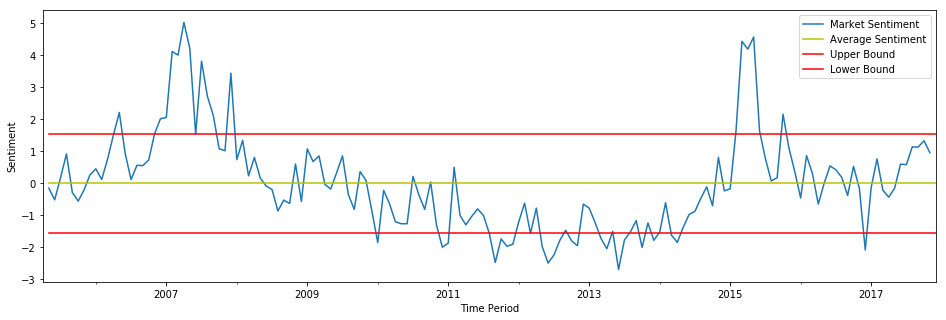

In [16]:
plt.figure(1,figsize = (16,5)) #plots the upper and lower bound of the 
ax = plt.gca()

df2.plot(kind='line',y='Market Sentiment',ax=ax)
df2.plot(kind='line',y='Average Sentiment', color = 'y',ax=ax)
df2.plot(kind='line',y='Upper Bound', color = 'red',ax=ax)
df2.plot(kind='line',y='Lower Bound', color='red', ax=ax)
plt.xlabel('Time Period')
plt.ylabel('Sentiment')
plt.xlim(['2005-04-30', '2017-12-31'])
plt.show()

In [17]:
df2.loc[df2['Market Sentiment'] > df2['Upper Bound'], 'Tracker'] = '1'
df2.loc[df2['Market Sentiment'] < df2['Lower Bound'], 'Tracker'] = '4'
df2.loc[(df2['Upper Bound'] > df2['Market Sentiment']) & (df2['Market Sentiment']> df2['Average Sentiment']), 'Tracker'] = '2'
df2.loc[(df2['Lower Bound'] < df2['Market Sentiment']) & (df2['Market Sentiment']< df2['Average Sentiment']), 'Tracker'] = '3'

In [18]:
df4 = pd.read_excel('D:\PHBS\Module 3\Investments\Final Project\Index\Final\data2.xlsx')
df4.set_index('Date', inplace = True)
df2['HS300 Index Return'] = df4['HS300 Index Return']

#set the free rate return
df2['Strategy Return'] = 1.003
df2.loc[df2['Tracker'] == '1', 'Strategy Return'] = df2['HS300 Index Return']
df2.loc[df2['Tracker'] == '3', 'Strategy Return'] = df2['HS300 Index Return']
df2['Cumulative Strategy Return'] = ((df2['Strategy Return'].cumprod() - 1)*100)
df2['Cumulative HS300 Return'] = ((df2['HS300 Index Return'].cumprod() - 1)*100)

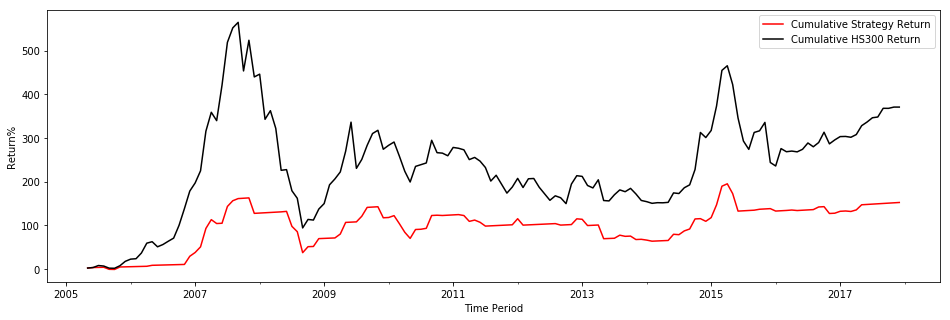

In [19]:
plt.figure(1,figsize = (16,5)) #plots the upper and lower bound of the 
ax = plt.gca()

df2.plot(kind='line',y='Cumulative Strategy Return',color = 'r',ax=ax)
df2.plot(kind='line',y='Cumulative HS300 Return', color = 'black',ax=ax)
plt.xlabel('Time Period')
plt.ylabel('Return%')
plt.show()

In [20]:
df2[df2['Strategy Return'] == df2['HS300 Index Return']].count()

SMT                           76
Market Sentiment              76
Lower Bound                   76
Upper Bound                   76
Average Sentiment             76
Tracker                       76
HS300 Index Return            76
Strategy Return               76
Cumulative Strategy Return    76
Cumulative HS300 Return       76
dtype: int64

In [21]:
df2.to_excel('D:\PHBS\Module 3\Investments\Final Project\Index\Final\staticreturns.xlsx')